# Imports

In [1]:
import tkinter
from PIL import Image, ImageTk, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.csgraph import shortest_path
import scipy.stats as sts
import os
from joblib import Parallel, delayed, dump, load
import tempfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Get X3 - the input to Net-3

In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
dir_path = 'X/3/'
lst = os.listdir(dir_path)
if 'X3' in locals():
    del X3
for img in lst:
    img_in = load_img(dir_path+img,target_size=(224,224),color_mode='rgb')
    input_arr = tf.keras.preprocessing.image.img_to_array(img_in)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    try:
        X3 = np.concatenate((X3,normalization_layer(input_arr)),axis=0)
    except:
        X3 = normalization_layer(input_arr)
print(X3.shape, np.min(X3), np.max(X3))

(18, 224, 224, 3) 0.0 0.9294118


# Get y3 - the output to Net-3

In [9]:
dir_path = 'y/3/'
lst = os.listdir(dir_path)
if 'y3' in locals():
    del y3
for img in lst:
    img_in = load_img(dir_path+img,target_size=(224,224),color_mode='grayscale')
    input_arr = tf.keras.preprocessing.image.img_to_array(img_in)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    try:
        y3 = np.concatenate((y3,normalization_layer(input_arr)),axis=0)
    except:
        y3 = normalization_layer(input_arr)
print(y3.shape, np.min(y3), np.max(y3))

(18, 224, 224, 1) 0.0 1.0


# Get X6 - the input to Net-6

In [10]:
base_lst = glob.glob('X/6/*.png')
ch4_lst = glob.glob('X/6/*.4')
ch5_lst = glob.glob('X/6/*.5')
ch6_lst = glob.glob('X/6/*.6')
base_lst[0].split('\\')
if 'X6' in locals():
    del X6
for img, ch4, ch5, ch6 in zip(base_lst, ch4_lst, ch5_lst, ch6_lst):
    img_in = load_img(img,target_size=(224,224),color_mode='rgb')
    input_arr = tf.keras.preprocessing.image.img_to_array(img_in)
    # take negative image of ch5 to see if that helps fitting
#     file = load_img(ch5,target_size=(224,224),color_mode='grayscale')
#     input_arr = np.concatenate((input_arr,np.random.rand),axis=2)
    for file in [ch4, ch5, ch6]:
#     for file in [ch4, ch6]:
        file = load_img(file,target_size=(224,224),color_mode='grayscale')
        input_arr = np.concatenate((input_arr,img_to_array(file)),axis=2)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    try:
        X6 = np.concatenate((X6,normalization_layer(input_arr)),axis=0)
    except:
        X6 = normalization_layer(input_arr)
print(X6.shape, np.min(X6), np.max(X6))

(18, 224, 224, 6) 0.0 1.0


# Get y6 - the output to Net-6

In [11]:
dir_path = 'y/6/'
lst = os.listdir(dir_path)
if 'y6' in locals():
    del y6
for img in lst:
    img_in = load_img(dir_path+img,target_size=(224,224),color_mode='grayscale')
    input_arr = tf.keras.preprocessing.image.img_to_array(img_in)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    try:
        y6 = np.concatenate((y6,normalization_layer(input_arr)),axis=0)
    except:
        y6 = normalization_layer(input_arr)
print(y6.shape, np.min(y6), np.max(y6))

(18, 224, 224, 1) 0.0 1.0


# Spot-check that the images are entered and oriented correctly

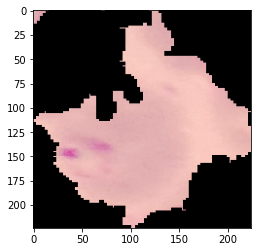

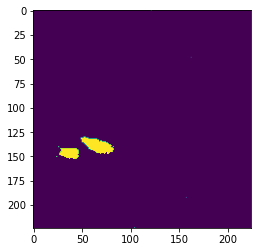

In [12]:
n=1
plt.imshow(tf.keras.preprocessing.image.array_to_img(X3[n]));
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(y3[n]));

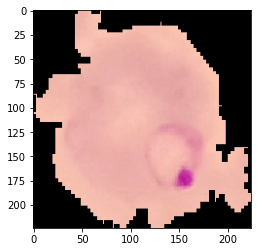

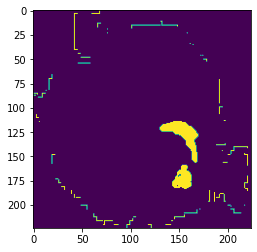

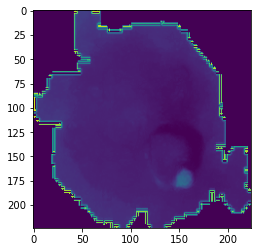

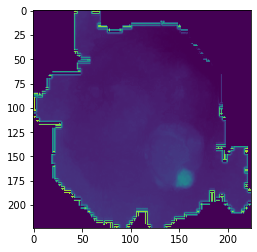

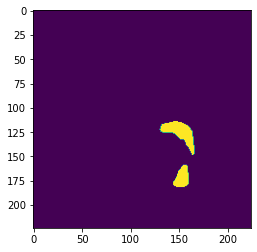

In [13]:
n=2
plt.imshow(tf.keras.preprocessing.image.array_to_img(X6[n][:,:,:3]));
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(X6[n][:,:,3].reshape((224,224,1))));
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(X6[n][:,:,4].reshape((224,224,1))));
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(X6[n][:,:,5].reshape((224,224,1))));
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(y6[n]));

## Create the net-3 neural network

In [14]:
def vgg_block(num_convs, num_filters, dil_rate):
    """
    Define the blocks of convolutional layers
    as per the reference paper which is based
    on VGG-16.
    
    Inputs:
    num_convs : number of convolutional layers
    num_filters : number of filters in each conv
    dil_rate : dilation rate for each conv
    
    Outputs:
    blk : the block of conv layers
    """
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_filters, 
                                   kernel_size=3,
                                   padding='same',
                                   dilation_rate=dil_rate,
                                   activation='relu'))
    return blk

def get_net(num_channels):

    """
    Define the overall neural network as per
    the reference paper which is based on VGG-16.
    
    Input:
    num_channels : number of channels
                   3 for just RGB
                   6 for RGB + 2 x geodesic + region map
                   
    Output:
    model
    """
    H, W, C = 224, 224, 32    # height, width, filters

    # define the input shape
    img_inputs = tf.keras.Input(shape=(H, W, num_channels))

    # define the individual blocks
    blk_1 = vgg_block(2, C, 1) #  number of of: conv2D layers, channels, dilation rate
    blk_2 = vgg_block(2, C, 2)
    blk_3 = vgg_block(3, C, 4)
    blk_4 = vgg_block(3, C, 8)
    blk_5 = vgg_block(3, C, 16)

    # build the sequence
    p1 = blk_1(img_inputs) # Block 1 output, with C channels
    p2 = blk_2(p1)         # Block 2 output, with C channels
    p3 = blk_3(p2)         # Block 3 output, with C channels
    p4 = blk_4(p3)         # Block 4 output, with C channels
    p5 = blk_5(p4)         # Block 5 output, with C channels

    # Block 6 elements defined
    drp1 = tf.keras.layers.Dropout(0.5)
    drp2 = tf.keras.layers.Dropout(0.5)
    cv1 = tf.keras.layers.Conv2D(2*C,
                                 kernel_size=1,
                                 padding='same', 
                                 dilation_rate=1,
    #                             kernel_initializer='he_uniform',
                                 activation='relu')
    cv2 = tf.keras.layers.Conv2D(2,
                                 kernel_size=1,
                                 padding='same', 
                                 dilation_rate=1,
    #                             kernel_initializer='he_uniform',
                                 activation='relu')
    sfmx = tf.keras.layers.Dense(1, activation='sigmoid')

    # Build Block 6
    # concatination layer with 5C channels
    q1 = tf.keras.layers.Concatenate()([p1, p2, p3, p4, p5])
    q2 = drp1(q1)  # drop-out layer
    q3 = cv1(q2)   # 1x1 convolution layer
    q4 = drp2(q3)  # drop-out layer
    q5 = cv2(q4)   # 1x1 convolution layer
    output = sfmx(q5) 

    model = tf.keras.Model(inputs=img_inputs,
                           outputs=output,
                           name="segnet_"+str(num_channels)+"_model")
    return model

# Neural Network

## Create the net-3 neural network

In [20]:
model = get_net(3)
model.summary()

Model: "segnet_3_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 224, 224, 32) 10144       input_2[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 224, 224, 32) 18496       sequential_5[0][0]               
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 224, 224, 32) 27744       sequential_6[0][0]               
_____________________________________________________________________________________

In [21]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy",
              metrics="binary_crossentropy",
              optimizer=adam)

model.fit(x=X3, y=y3, epochs=50, batch_size=3)

Epoch 1/50
6/6 [==============================] - 1s 146ms/step - loss: 0.7609 - binary_crossentropy: 0.7609
Epoch 2/50
6/6 [==============================] - 1s 143ms/step - loss: 0.1802 - binary_crossentropy: 0.1802
Epoch 3/50
6/6 [==============================] - 1s 142ms/step - loss: 0.0743 - binary_crossentropy: 0.0743
Epoch 4/50
6/6 [==============================] - 1s 143ms/step - loss: 0.0666 - binary_crossentropy: 0.0666
Epoch 5/50
6/6 [==============================] - 1s 143ms/step - loss: 0.0639 - binary_crossentropy: 0.0639
Epoch 6/50
6/6 [==============================] - 1s 142ms/step - loss: 0.0622 - binary_crossentropy: 0.0622
Epoch 7/50
6/6 [==============================] - 1s 143ms/step - loss: 0.0586 - binary_crossentropy: 0.0586
Epoch 8/50
6/6 [==============================] - 1s 143ms/step - loss: 0.0604 - binary_crossentropy: 0.0604
Epoch 9/50
6/6 [==============================] - 1s 142ms/step - loss: 0.0614 - binary_crossentropy: 0.0614
Epoch 10/50
6/6 [==

# Make prediction on input dataset

In [22]:
y_pred = model(X3)
y_pred.shape

TensorShape([18, 224, 224, 1])

# Check a result

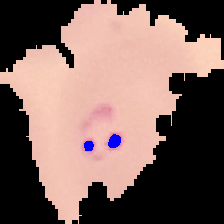

In [30]:
n=13
y_p = tf.keras.preprocessing.image.array_to_img(y_pred[n])
#print(np.shape(y_pred), np.shape(y_p), np.min(y_p), np.max(y_p))
img = tf.keras.preprocessing.image.array_to_img(X3[n])
for i in range(img.height):
    for j in range(img.width):
        if y_p.getpixel((i,j)) >= 127:
            img.putpixel((i,j),(0,0,255))
img

## Create the net-6 neural network

In [39]:
net6 = get_net(6)
net6.summary()

Model: "segnet_6_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 6) 0                                            
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 224, 224, 32) 11008       input_5[0][0]                    
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 224, 224, 32) 18496       sequential_20[0][0]              
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 224, 224, 32) 27744       sequential_21[0][0]              
_____________________________________________________________________________________

In [40]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
net6.compile(loss="binary_crossentropy",
              metrics="binary_crossentropy",
              optimizer=adam)

net6.fit(x=X6, y=y6, epochs=200, batch_size=6)

Epoch 1/200
3/3 [==============================] - 1s 190ms/step - loss: 0.6806 - binary_crossentropy: 0.6806
Epoch 2/200
3/3 [==============================] - 1s 284ms/step - loss: 0.5937 - binary_crossentropy: 0.5937
Epoch 3/200
3/3 [==============================] - 1s 283ms/step - loss: 0.3541 - binary_crossentropy: 0.3541
Epoch 4/200
3/3 [==============================] - 1s 284ms/step - loss: 0.2351 - binary_crossentropy: 0.2351
Epoch 5/200
3/3 [==============================] - 1s 284ms/step - loss: 0.1771 - binary_crossentropy: 0.1771
Epoch 6/200
3/3 [==============================] - 1s 284ms/step - loss: 0.1549 - binary_crossentropy: 0.1549
Epoch 7/200
3/3 [==============================] - 1s 284ms/step - loss: 0.1304 - binary_crossentropy: 0.1304
Epoch 8/200
3/3 [==============================] - 1s 284ms/step - loss: 0.1034 - binary_crossentropy: 0.1034
Epoch 9/200
3/3 [==============================] - 1s 283ms/step - loss: 0.0812 - binary_crossentropy: 0.0812
Epoch 10/2

3/3 [==============================] - 1s 288ms/step - loss: 0.0061 - binary_crossentropy: 0.0061
Epoch 73/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0060 - binary_crossentropy: 0.0060
Epoch 74/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0058 - binary_crossentropy: 0.0058
Epoch 75/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0059 - binary_crossentropy: 0.0059
Epoch 76/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0057 - binary_crossentropy: 0.0057
Epoch 77/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0056 - binary_crossentropy: 0.0056
Epoch 78/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0054 - binary_crossentropy: 0.0054
Epoch 79/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0052 - binary_crossentropy: 0.0052
Epoch 80/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0051 - binary_crossentropy: 0.0051
Epoch 81/200
3

3/3 [==============================] - 1s 289ms/step - loss: 0.0033 - binary_crossentropy: 0.0033
Epoch 146/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0031 - binary_crossentropy: 0.0031
Epoch 147/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0028 - binary_crossentropy: 0.0028
Epoch 148/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0030 - binary_crossentropy: 0.0030
Epoch 149/200
3/3 [==============================] - 1s 288ms/step - loss: 0.0025 - binary_crossentropy: 0.0025
Epoch 150/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0025 - binary_crossentropy: 0.0025
Epoch 151/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0026 - binary_crossentropy: 0.0026
Epoch 152/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0023 - binary_crossentropy: 0.0023
Epoch 153/200
3/3 [==============================] - 1s 289ms/step - loss: 0.0024 - binary_crossentropy: 0.0024
Epoch 

# Make prediction on input dataset

In [41]:
y_pred = net6(X6)
y_pred.shape

TensorShape([18, 224, 224, 1])

# Check a result

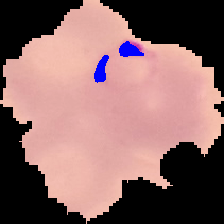

In [45]:
n=3
y_p = tf.keras.preprocessing.image.array_to_img(y_pred[n])
#print(np.shape(y_pred), np.shape(y_p), np.min(y_p), np.max(y_p))
img = tf.keras.preprocessing.image.array_to_img(X6[n][:,:,:3])
for i in range(img.height):
    for j in range(img.width):
        if y_p.getpixel((i,j)) >= 127:
            img.putpixel((i,j),(0,0,255))
img

# Save the models if improved

In [46]:
model.save("Model_003")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_003\assets


In [47]:
net6.save("Net6_003")

INFO:tensorflow:Assets written to: Net6_003\assets
